## am4 random forest prelim

In [1]:
import json
BASEDIR = "../data/am4aqua/am4_all_cyclones.json"

with open(BASEDIR) as f:
    am4runs = json.load(f)
len(am4runs)

9

In [2]:
am4runsflat = {}
for sstmax in am4runs.keys():
    for date in am4runs[sstmax].keys():
        am4runsflat[f"{sstmax}_{date}"] = am4runs[sstmax][date]
del am4runs
len(am4runsflat)

2349

## preprocessing 


In [3]:
import numpy as np

def get_train_test_idx(indict:dict,seed=42,split=0.3):
    train_to = int(np.ceil((1-split)*len(indict)))
    rng = np.random.default_rng(seed=seed)
    keys = list(indict.keys())
    rng.shuffle(keys)
    return set(keys[:train_to]),set(keys[train_to:])

Calculate coriolis parameter 
$$
f = 2\Omega\sin\lambda 
$$
where $\lambda$ is latitude.
So we only predict max sustained wind speed, min pressure, u,v. We can interpolate all other parameters -> first using the intial speed speed to interpolate latitude/longitude from predicted speed. Then use the predicted lat to calculate $f$ and $T_{SST}$

In [4]:
train,test = get_train_test_idx(am4runsflat,split=0.1)
x_trainval = {k:v for k,v in am4runsflat.items() if k in train}
x_test = {k:v for k,v in am4runsflat.items() if k in test}
train,val = get_train_test_idx(x_trainval,split=0.25)
x_train = {k:v for k,v in x_trainval.items() if k in train}
x_val = {k:v for k,v in x_trainval.items() if k in val}

In [5]:
def process_into_chunks(data:dict,timestep:int=5,train_idx=None,prediction_idx=None,sstmaxidx=None):
    X = []
    y = []
    sstmax = []
    for item in data.values():
        for t in range(1,len(item)-timestep-1):
            if train_idx:
                X.append([ [item[t+i][k] for k in train_idx  ]for i in range(timestep)])
            else:
                X.append([ item[t+i] for i in range(timestep)])
            if sstmaxidx:
                sstmax.append(item[t][sstmaxidx])
            if prediction_idx:
                pred = item[t+timestep]
                y.append([ item[t+timestep][idx] for idx in prediction_idx])
            else:
                y.append(item[t+timestep])
    return np.stack(X),np.stack(y),np.stack(sstmax)

def get_storm_seeds(data:dict,timestep:int=5,train_idx=None,sstmaxidx=None):
    """
    Similar but generates X, vector of storm seed and y, vector of entire storm prediction track
    """
    X,y,sstmax = [],[],[]
    for item in data.values():
        if train_idx:
            X.append([ [item[i+1][k] for k in train_idx ]for i in range(timestep)])
        else:
            X.append([ item[i+1] for i in range(timestep)])
        if sstmaxidx:
            sstmax.append(item[0][sstmaxidx])
        y.append(np.array(item[1:]))    
    return np.stack(X),y,np.stack(sstmax)


In [6]:
TRAIN_IDX = (
    0,#Longitude
    1,#Latitude
    2,#Maximum Sustained wind speed,
    3,#Minimum Pressure
    5,#Sea Surface Temperature,
    7,#Coriolis Parameter
    8,#Horizontal Storm Speed,
    9,#Vertical Storm Speed
)

PREDICTION_IDX=(
    2,# Maximum Sustained Wind Speed,
    3,# Minimum Pressure
    8,# horizontal storm speed,
    9,# vertical storm speed
)

X_train,y_train,train_sstmax = process_into_chunks(x_train,timestep=10,train_idx=TRAIN_IDX,prediction_idx=PREDICTION_IDX,sstmaxidx=6)
X_validation,y_validation,val_sstmax = process_into_chunks(x_val,timestep=10,train_idx=TRAIN_IDX,prediction_idx=PREDICTION_IDX,sstmaxidx=6)

## Training

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train.reshape((-1,X_train.shape[-1]*X_train.shape[-2])),y_train)

RandomForestRegressor(n_jobs=-1)

In [8]:
y_valpredict = rf.predict(X_validation.reshape((-1,X_validation.shape[-1]*X_validation.shape[-2])))

In [9]:
y_validation[2],y_valpredict[2]

(array([ 2.44500000e+01,  9.89040000e+02, -9.42033872e+00,  3.54263216e-02]),
 array([ 25.9804    , 986.0345    ,  -5.11798446,   2.82304826]))

Root mean square error for each coefficent

In [10]:
np.sqrt(np.sum((y_validation - y_valpredict)**2,axis=0)/len(y_validation))

array([1.98531626, 2.7407664 , 2.3518559 , 2.36139231])

## Predictions

In [11]:
from geopy.distance import distance
from geopy.point import Point

def get_predicted_latlon_from_speed(lat,lon,u,v):
    d = np.sqrt(u**2 + v**2)*6*3.6 ## convert to kilometers across 6 hours intervals
    bearing = np.rad2deg(np.arctan2(u,v))
    predicted = distance(kilometers=d).destination(Point(latitude=lat,longitude=lon),bearing)
    return predicted.latitude,predicted.longitude%360


def coriolis_parameter(lat:float):
    """
    Coriolis parameter important TC parameter, proportional to earth roation rate 
    """
    return 2*np.sin(np.deg2rad(lat)) #

def SST(lat:float,sstmaxlat:float):
    if lat > 60 or lat < -60:
        return 0 
    elif  lat > sstmaxlat:
        return 27*(1 - np.sin(90*(lat*np.pi/180 - sstmaxlat*np.pi/180)/(60 - sstmaxlat))**2)
    else:
        return 27*(1 - np.sin(90*(lat*np.pi/180 - sstmaxlat*np.pi/180)/(60 + sstmaxlat))**2)


def recursive_prediction(initial_x,sstmax,model,length):
    y = np.zeros((length,6))
    timestep = initial_x.shape[0]
    y[:timestep] = initial_x[:,(2,3,6,7,1,0)]
    x = initial_x
    for step in range(length - timestep):
        uMax,Pmin,u,v = model.predict(x.reshape(1,-1))[0]
        old_lat,old_lon = x[-1,1],x[-1,0]
        interp_lat,interp_lon = get_predicted_latlon_from_speed(old_lat,old_lon,u,v)
        y[step+timestep] = [uMax,Pmin,u,v,interp_lat,interp_lon]

        x = np.roll(x,-1,axis=0)
        x[-1] = [interp_lon,interp_lat,uMax,Pmin,SST(interp_lat,sstmax),coriolis_parameter(interp_lat),u,v]
    return y 




In [14]:
valstorm_seed,valstorm_truth,valstorm_sstmax = get_storm_seeds(x_val,timestep=10,train_idx=TRAIN_IDX,sstmaxidx=6)


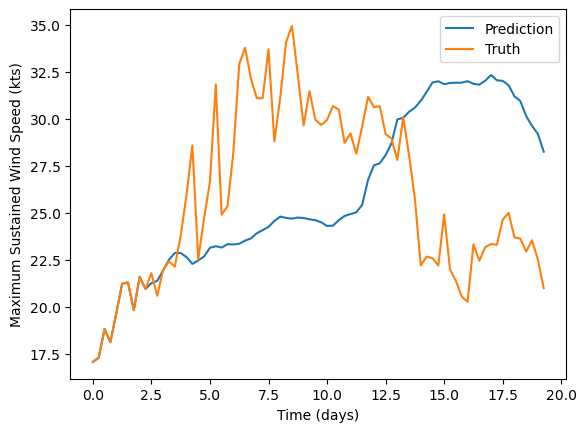

In [28]:
import matplotlib.pyplot as plt
STORM = 317
prediction_length = len(valstorm_truth[STORM]) 
storm_predictions = recursive_prediction(valstorm_seed[STORM],valstorm_sstmax[STORM],rf,prediction_length)
t=np.arange(0,prediction_length/4,0.25)
plt.plot(t,storm_predictions[:,0],label='Prediction')
plt.plot(t[:len(valstorm_truth[STORM])],valstorm_truth[STORM][:,2],label='Truth')
plt.xlabel("Time (days)")
plt.ylabel("Maximum Sustained Wind Speed (kts)")
plt.legend()

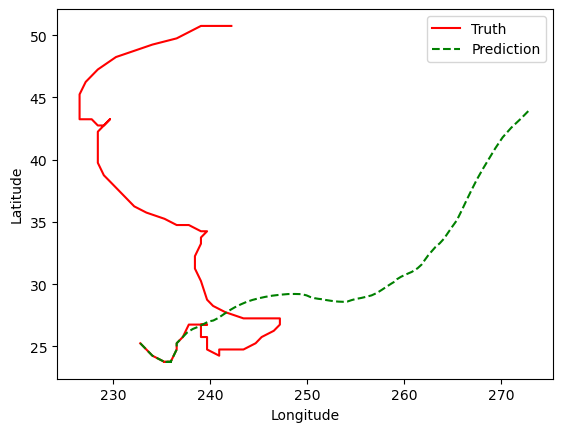

In [29]:
plt.plot(valstorm_truth[STORM][:,0],valstorm_truth[STORM][:,1],'r-',label="Truth")
plt.plot(storm_predictions[:,5],storm_predictions[:,4],'g--',label="Prediction")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

In [27]:
np.argsort([len(v) for v in valstorm_truth])[::-1]

array([111, 317, 487, 303, 202, 258, 339, 492, 133, 505, 450, 265, 195,
       144, 181, 499, 274, 442, 209, 194, 224, 327, 270, 437, 204, 361,
       516, 421, 420, 372, 334, 269, 167, 343, 424, 310, 500,  59, 428,
       145, 417, 230, 271, 377, 520, 259, 115, 107, 333, 233, 296, 353,
       336, 153, 510, 164, 497, 472, 431, 148, 163, 454, 506,  87, 444,
       266, 331, 443, 438, 517, 480, 277, 412, 287, 388, 272, 279, 416,
         8,  95, 309, 473, 457, 365,  33, 290, 114, 408, 491, 390, 511,
       165, 288, 275, 291, 387, 359, 351, 174, 293, 234, 348, 427, 149,
        51, 281, 112, 469, 246, 386, 264, 526, 302, 466, 197, 452, 379,
       504, 490, 241, 503, 137, 328, 177, 366, 215, 214, 203,   4, 311,
       463, 426, 332, 462, 392, 352, 160,  36, 397, 316,  32, 349, 458,
        47, 308, 465, 108,  71, 478, 169,  27, 175, 326,  23, 127, 297,
       103, 186, 451, 182, 330, 278, 400,  99, 521, 344, 345, 141,  84,
       401, 435, 445,  96, 282, 486, 479, 109, 251, 459, 512, 41